<a href="https://colab.research.google.com/github/Aman10022006/Group_4/blob/main/Wafer%20defect%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os.path import join

import numpy as np
import pandas as pd
import scipy.io as sio

import tensorflow as tf
import keras
from keras import layers, Input, models
#from keras.utils import to_categorical
!pip install scikeras
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

wafer_bins=pd.read_pickle("LSWMD.pkl")
wafer_bins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
#We can see that we will be able to use 811457 wafermaps for the deep learning to detect all detections

#After having looked in the dataset, we can see that there is several types of mapping (9 precisely), and data
#either for the training or the test. So let's rearrange these information.

wafer_bins['failureNum']=wafer_bins.failureType
wafer_bins['trainTestNum']=wafer_bins.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
wafer_bins=wafer_bins.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
wafer_bins['waferMapDim']=wafer_bins.waferMap.apply(find_dim)

wafer_bins.sample(10)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,failureNum,trainTestNum,waferMapDim
635999,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot40049,5.0,[],[],[],[],"(32, 29)"
269654,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4096.0,lot16639,11.0,[],[],[],[],"(72, 72)"
165868,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot10600,19.0,[],[],[],[],"(26, 26)"
403861,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1,...",518.0,lot24177,6.0,[],[],[],[],"(27, 25)"
163310,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot10494,13.0,[],[],[],[],"(212, 84)"
572512,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot35828,12.0,[],[],[],[],"(32, 29)"
594095,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot37178,8.0,[],[],[],[],"(49, 39)"
29501,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",555.0,lot2996,4.0,[],[],[],[],"(27, 27)"
56265,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot4517,2.0,[],[],[],[],"(32, 29)"
688106,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1233.0,lot42541,4.0,[[Test]],[[none]],8,1,"(41, 38)"


In [ ]:
#In this document, we have to choose which wafermaps we need. Because, there are many in which we can see that the
#labels have a pattern (we need these ones), and some label without a pattern.

#From now on, I will call the variable wafer_bins wb.
wb=wafer_bins

#Our database will be reduced for sure, so let's see how much it will be.

wb_withlabel = wb[(wb['failureNum']>=0) & (wb['failureNum']<=8)]
wb_withlabel =wb_withlabel.reset_index()
wb_withpattern = wb[(wb['failureNum']>=0) & (wb['failureNum']<=7)]
wb_withpattern = wb_withpattern.reset_index()
wb_nonpattern = wb[(wb['failureNum']==8)]
print(wb_withlabel.shape[0], wb_withpattern.shape[0], wb_nonpattern.shape[0])

172950 25519 147431


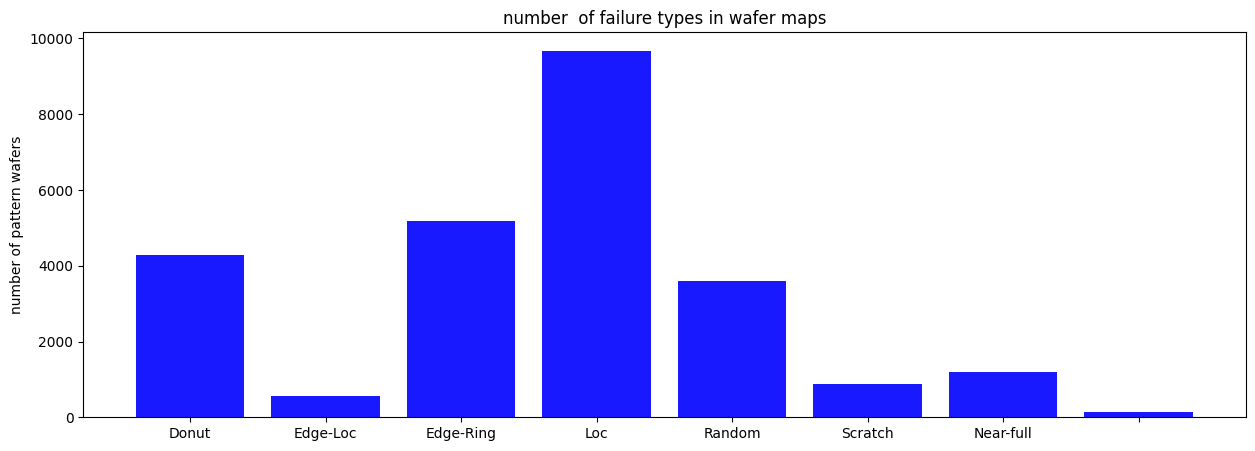

In [ ]:
#As we can see, we only choose those we need, so we just don't study the None failure types nor the non-labelled
#wafer maps. So we just keep the 25519 wafer maps we need, it really reduces the amount of work. But we still have to
#remove the null label. And from now on, we will work with this reduced database.

wb=wb_withpattern
for i in range(len(wb)):
    if len(wb.iloc[i,:]['failureType']) == 0:
        wb.remove(wb[i])

#Let's show how is organized the distribution of the Failure Types:

%matplotlib inline

fig = plt.figure(figsize=(15, 5))
axe=plt.subplot(1,1,1)

uni_pattern=np.unique(wb.failureNum, return_counts=True)
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
axe.bar(uni_pattern[0],uni_pattern[1], color='blue', align='center', alpha=0.9)
axe.set_title("number  of failure types in wafer maps")
axe.set_ylabel("number of pattern wafers")
axe.set_xticklabels(labels)

plt.show()

In [ ]:
#Now we have all the Failure Types we want, we will be able to start the deep learning, and as this problem is
#sequential, we will use the sequence to sequence model.

#So now, let's settle the parameters of the encoder part.

#Our encoder will be composed with a stack of several convolutional neutral networks (CNNs) units where each accepts a
#single element of the input sequence, collects information for that element and propagates it forward.

#But first, we need a precise shape for the wafer maps we will use, it has to be a square, so we have to choose a
#shape, and then we have to create a list of images which are in this shape, and their associated failure types

sub_wb = wb.loc[wb['waferMapDim'] == (26, 26)]

Imlist = np.ones((1, 26, 26))
label = []

for i in range(len(sub_wb)):
    Imlist = np.concatenate((Imlist, sub_wb.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_wb.iloc[i,:]['failureType'][0][0])

#The first elemet in Imlist is just composed with ones, so it isn't intersesting, let's remove it
Imlist=Imlist[1:]
label=np.array(label).reshape((-1,1)) #Column of labels
print(Imlist[756][0][10], Imlist[756][0][9], Imlist[756][0][11])
#We have all the values of the pixels: 0.0 is for the exterior ofthe wafer map, 2.0 is for the local impure pixel, and
#1.0 is for a pure pixel of the wafer map

print(np.shape(Imlist),np.shape(label))

2.0 0.0 1.0
(877, 26, 26) (877, 1)


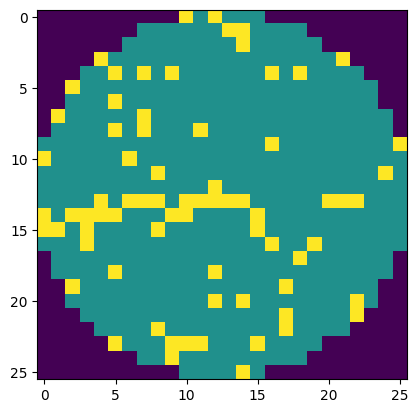

label assiociated :  ['Scratch']
Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72


In [ ]:
#This not the most important part, but we can plot the defected wafer map, if we want to. The 511th data for example
plt.imshow(Imlist[756])
plt.show()
print("label assiociated : ", label[756])
#Also we can see how much defect labels in this dataset

for l in np.unique(label) :
    print('{} : {}'.format(l, len(label[label==l])))

In [ ]:
Imlist=Imlist.reshape((-1,26,26,1))
#With that, each pixel of each image is separated and we will be able to use them separately in order to process the
#deep learning

new_Imlist = np.zeros((len(Imlist), 26, 26, 3))

for w in range(len(Imlist)):
    for i in range(26):
        for j in range(26):
            new_Imlist[w, i, j, int(Imlist[w, i, j])] = 1

#In order to process to the deep learning, we have to use data compsed by 1 only. So we have to transform these
#0.0, 1.0 or 2.0 in a sequence of 1 and 0. So with these loops, we can say:
    #for 0.0: [1,0,0]
    #for 1.0: [0,1,0]
    #for 2.0: [0,0,1]
#And now we can settle our process of deep learning

In [ ]:
#We have to prepare some data for the training and the test, and define the encoder and decoder.

epoch=30
batch_size=877

input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)
#Relu activation function, in this case, just keep the values we are convoluting, and it let us do the same for the
#output tensor created.

#Now that the encoder is settled, we have to code the latent vector, which is the last part of the encoder, and it aims
#to encapsulate the information for all input elements in order to help the decoder make accurate predictions.
#It acts as the initial hidden state of the decoder part of the model.

#Only the highest value of a region is kept.Max pooling is akeeping the most activated pixels (ones with the highest
#values) and discards the rest.

latent_vector = layers.MaxPool2D()(encode)

encoder = models.Model(input_tensor, latent_vector)

#And now the decoder, and then connecting all the layers, to finally have the predicted output tensor. A stack of
#several recurrent units where each predicts an outputEach recurrent unit accepts a hidden state from the previous
#unit and produces and output as well as its own hidden state.

decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu') #It is the transposed
#convolution layer, so the inverse step as the encoder
decode_layer_2 = layers.UpSampling2D() #Repeats the rows and columns of the data by size[0] and size[1] respectively.
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

#After having regarding the shape I needed for the start of the decoder, I have to define it.
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

#Now we have all the model, let's prepare the dataset, with normal wafers, and noised wafers, so that we will have some
#data to make the machine predict their label

encoded_Im = encoder.predict(new_Imlist)
noised_encoded_Im = encoded_Im + np.random.normal(loc=0, scale=0.1, size = (len(encoded_Im), 13, 13, 64))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
#When you train a deep learning model, what you’re really doing is tuning its parameters such that it can map a
#particular input (say, an image) to some output (a label). Our optimization goal is to chase that sweet spot where our
#model’s loss is low, which happens when your parameters are tuned in the right way.

#So, to get more data, we just need to make minor alterations to our existing dataset. Minor changes such as flips or
#translations or rotations. Our neural network would think these are distinct images anyway.

#So here is our augmentation function

def gen_data(wafer, label):
    encoded_x = encoder.predict(wafer)

    gen_x = np.zeros((1, 26, 26, 3)) # Dummy array for collecting noised wafer

    for i in range((1500//len(wafer)) + 1): # Make wafer until total of wafer to 1500
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)

    gen_y = np.full((len(gen_x), 1), label) # Also make label vector with same length

    return gen_x[1:], gen_y[1:]  # Return date without 1st dummy data.

#And we can apply this function to our dataset to have it full of noised wafer maps

for l in np.unique(label):
    gen_x, gen_y = gen_data(new_Imlist[np.where(label==l)[0]], l)
    new_Imlist = np.concatenate((new_Imlist, gen_x), axis=0)
    label = np.concatenate((label, gen_y))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

In [ ]:
#Now we can see the shape of our lists, just to now how big is our dataset
for l in np.unique(label) :
    print('{} : {}'.format(l, len(label[label==l])))
print(np.shape(new_Imlist), np.shape(label))

Center : 1620
Donut : 1502
Edge-Loc : 2072
Edge-Ring : 1550
Loc : 2079
Near-full : 1520
Random : 1628
Scratch : 1584
(13555, 26, 26, 3) (13555, 1)


In [ ]:
#In order to process the test, we need a matrix of labels
for i, l in enumerate(np.unique(label)):
    label[label==l] = i

label = tf.keras.utils.to_categorical(label)

#Now we know this information, we can lower the heavyness of the dataset, because it is too huge
new_IMLIST=new_Imlist[0:13000]
new_LABEL=label[0:13000]
test_Imlist=new_Imlist[13001:13554]
test_label=label[13001:13554]
print(np.shape(new_LABEL))

(13000, 8)


In [ ]:
#We have to split our slighter dataset in order to process the test
im_train, im_test, label_train, label_test = train_test_split(new_IMLIST, new_LABEL, test_size=0.33, random_state=2019)
print(np.shape(im_train),np.shape(im_test),np.shape(label_train),np.shape(label_test))

(8710, 26, 26, 3) (4290, 26, 26, 3) (8710, 8) (4290, 8)


In [ ]:
#Let's now create the real model we will use for the CNN test
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(8, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [ ]:
from scikeras.wrappers import KerasClassifier  # Use SciKeras version

In [ ]:
!pip install --upgrade scikeras scikit-learn


In [ ]:
model = KerasClassifier(model=create_model, epochs=30, batch_size=877, verbose=2)


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Define the model function
def create_model():
    model = tf.keras.models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(im_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Convert data to NumPy arrays
im_train = np.array(im_train)
label_train = np.array(label_train)

# Reshape im_train if needed
if len(im_train.shape) > 2:
    im_train = im_train.reshape(im_train.shape[0], -1)

# K-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019)
fold_accuracies = []

for train_idx, val_idx in kfold.split(im_train):
    x_train, x_val = im_train[train_idx], im_train[val_idx]
    y_train, y_val = label_train[train_idx], label_train[val_idx]

    # Create and train the model
    model = create_model()
    model.fit(x_train, y_train, epochs=30, batch_size=877, verbose=2, validation_data=(x_val, y_val))

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(x_val, y_val, verbose=0)
    fold_accuracies.append(accuracy)

# Print cross-validation results
print("Cross-validation accuracies:", fold_accuracies)
print("Average training accuracy:", np.mean(fold_accuracies))


Epoch 1/30
7/7 - 2s - 278ms/step - accuracy: 0.1221 - loss: -1.2698e+01 - val_accuracy: 0.1157 - val_loss: -3.5928e+01
Epoch 2/30
7/7 - 0s - 46ms/step - accuracy: 0.1190 - loss: -5.4191e+01 - val_accuracy: 0.1157 - val_loss: -8.7628e+01
Epoch 3/30
7/7 - 0s - 37ms/step - accuracy: 0.1190 - loss: -1.1027e+02 - val_accuracy: 0.1157 - val_loss: -1.5486e+02
Epoch 4/30
7/7 - 0s - 33ms/step - accuracy: 0.1190 - loss: -1.8324e+02 - val_accuracy: 0.1157 - val_loss: -2.4263e+02
Epoch 5/30
7/7 - 0s - 33ms/step - accuracy: 0.1190 - loss: -2.7847e+02 - val_accuracy: 0.1157 - val_loss: -3.5596e+02
Epoch 6/30
7/7 - 0s - 60ms/step - accuracy: 0.1190 - loss: -4.0043e+02 - val_accuracy: 0.1157 - val_loss: -5.0081e+02
Epoch 7/30
7/7 - 1s - 86ms/step - accuracy: 0.1190 - loss: -5.5657e+02 - val_accuracy: 0.1157 - val_loss: -6.8289e+02
Epoch 8/30
7/7 - 1s - 90ms/step - accuracy: 0.1190 - loss: -7.4902e+02 - val_accuracy: 0.1157 - val_loss: -9.0969e+02
Epoch 9/30
7/7 - 0s - 50ms/step - accuracy: 0.1190 - lo

In [ ]:
print("im_test shape:", im_test.shape)  # Debug: Check feature size
print("label_test shape:", label_test.shape)  # Debug: Check label size


im_test shape: (4290, 2028)
label_test shape: (34320,)


In [ ]:
min_samples = min(im_test.shape[0], label_test.shape[0])
im_test = im_test[:min_samples]
label_test = label_test[:min_samples]

test_loss, test_acc = final_model.evaluate(im_test, label_test, verbose=2)
print("Final test accuracy:", test_acc)


135/135 - 0s - 3ms/step - accuracy: 0.1249 - loss: 52763.7891
Final test accuracy: 0.12494172155857086


In [ ]:
if label_test.ndim > 1 and label_test.shape[1] > 1:
    label_test = np.argmax(label_test, axis=1)  # Convert one-hot to single labels


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Define the model function
def create_model():
    model = tf.keras.models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(im_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Convert data to NumPy arrays
im_train = np.array(im_train)
label_train = np.array(label_train)

# Reshape im_train if needed
if len(im_train.shape) > 2:
    im_train = im_train.reshape(im_train.shape[0], -1)

# Ensure labels are correctly shaped
label_train = label_train.reshape(-1,)

# K-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019)
fold_accuracies = []

for train_idx, val_idx in kfold.split(im_train):
    x_train, x_val = im_train[train_idx], im_train[val_idx]
    y_train, y_val = label_train[train_idx], label_train[val_idx]

    # Create and train the model
    model = create_model()
    model.fit(x_train, y_train, epochs=30, batch_size=877, verbose=2, validation_data=(x_val, y_val))

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(x_val, y_val, verbose=0)
    fold_accuracies.append(accuracy)

# Print cross-validation results
print("Cross-validation accuracies:", fold_accuracies)
print("Average training accuracy:", np.mean(fold_accuracies))

# 🔹 **Final Model Training on Full Training Set**
final_model = create_model()
history = final_model.fit(im_train, label_train, epochs=30, batch_size=877, verbose=2)

# 🔹 **Validation on Test Set**
im_test = np.array(im_test).reshape(im_test.shape[0], -1)  # Reshape if needed
label_test = np.array(label_test).reshape(-1,)  # Ensure labels are shaped correctly
test_loss, test_acc = final_model.evaluate(im_test, label_test, verbose=2)

print("Final test accuracy:", test_acc)


Epoch 1/30
7/7 - 2s - 253ms/step - accuracy: 0.1214 - loss: -1.3486e+01 - val_accuracy: 0.1157 - val_loss: -3.9508e+01
Epoch 2/30
7/7 - 0s - 55ms/step - accuracy: 0.1190 - loss: -5.9905e+01 - val_accuracy: 0.1157 - val_loss: -9.8541e+01
Epoch 3/30
7/7 - 0s - 43ms/step - accuracy: 0.1190 - loss: -1.2667e+02 - val_accuracy: 0.1157 - val_loss: -1.8117e+02
Epoch 4/30
7/7 - 0s - 34ms/step - accuracy: 0.1190 - loss: -2.1582e+02 - val_accuracy: 0.1157 - val_loss: -2.8848e+02
Epoch 5/30
7/7 - 0s - 41ms/step - accuracy: 0.1190 - loss: -3.3268e+02 - val_accuracy: 0.1157 - val_loss: -4.2712e+02
Epoch 6/30
7/7 - 0s - 40ms/step - accuracy: 0.1190 - loss: -4.8257e+02 - val_accuracy: 0.1157 - val_loss: -6.0690e+02
Epoch 7/30
7/7 - 0s - 46ms/step - accuracy: 0.1190 - loss: -6.7789e+02 - val_accuracy: 0.1157 - val_loss: -8.3889e+02
Epoch 8/30
7/7 - 0s - 41ms/step - accuracy: 0.1190 - loss: -9.2688e+02 - val_accuracy: 0.1157 - val_loss: -1.1308e+03
Epoch 9/30
7/7 - 0s - 44ms/step - accuracy: 0.1190 - lo

In [ ]:
test_loss, test_acc = model.evaluate(im_test, label_test, verbose=2)
print("Testing Accuracy:", test_acc)


135/135 - 0s - 3ms/step - accuracy: 0.1249 - loss: 13414.4844
Testing Accuracy: 0.12494172155857086


In [ ]:
print("im_test shape:", im_test.shape)
print("label_test shape:", label_test.shape)

# Ensure the same number of samples
min_samples = min(im_test.shape[0], label_test.shape[0])
im_test = im_test[:min_samples]
label_test = label_test[:min_samples]

test_loss, test_acc = model.evaluate(im_test, label_test, verbose=2)
print("Final Test Accuracy:", test_acc)


im_test shape: (4290, 2028)
label_test shape: (4290,)
135/135 - 0s - 2ms/step - accuracy: 0.1249 - loss: 13414.4844
Final Test Accuracy: 0.12494172155857086


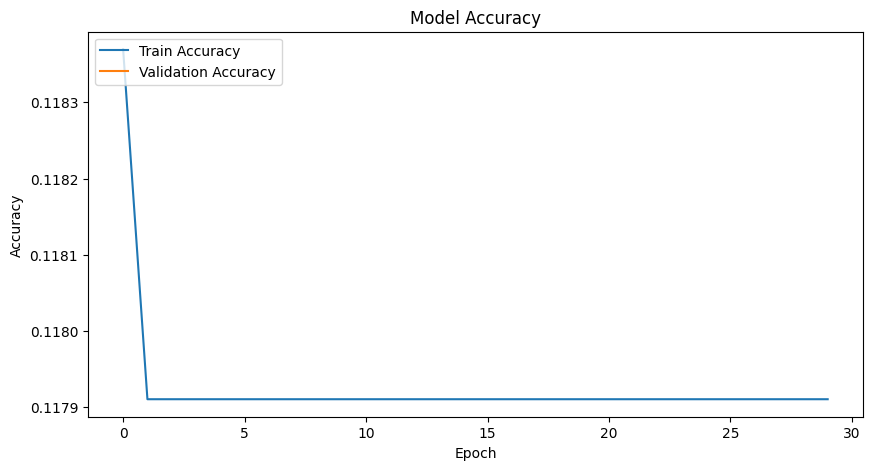

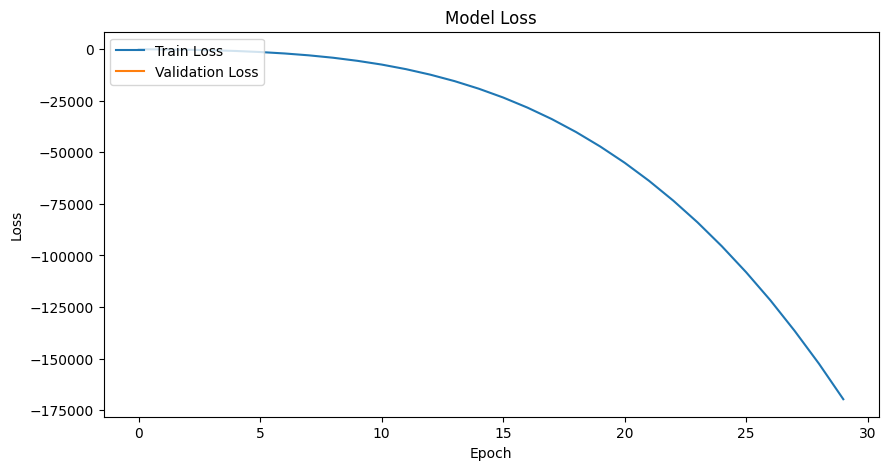

In [ ]:
import matplotlib.pyplot as plt

# Check if history exists
if history and hasattr(history, "history"):
    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
else:
    print("Error: 'history' object is None or missing training data.")
